In [1]:
import simpy, random, logging
from queue_simulation import (
    ServiceOperation, SIMULATION_DURATION, SEED,
    SocialWorkerShifts, DutyOfficerShifts, VolunteerShifts)

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import itertools

In [2]:
sns.set();

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager

# modify matplotlib and seaborn settings
# to display Chinese 
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP'] 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelweight'] = 'heavy'
plt.rcParams['font.weight'] = 'medium'

sns.set(font=['sans-serif'])
sns.set_style('dark',{'font.sans-serif':['Noto Serif CJK JP']})
sns.set_context('paper', font_scale=1.5)

# 1. plot counsellor shifts

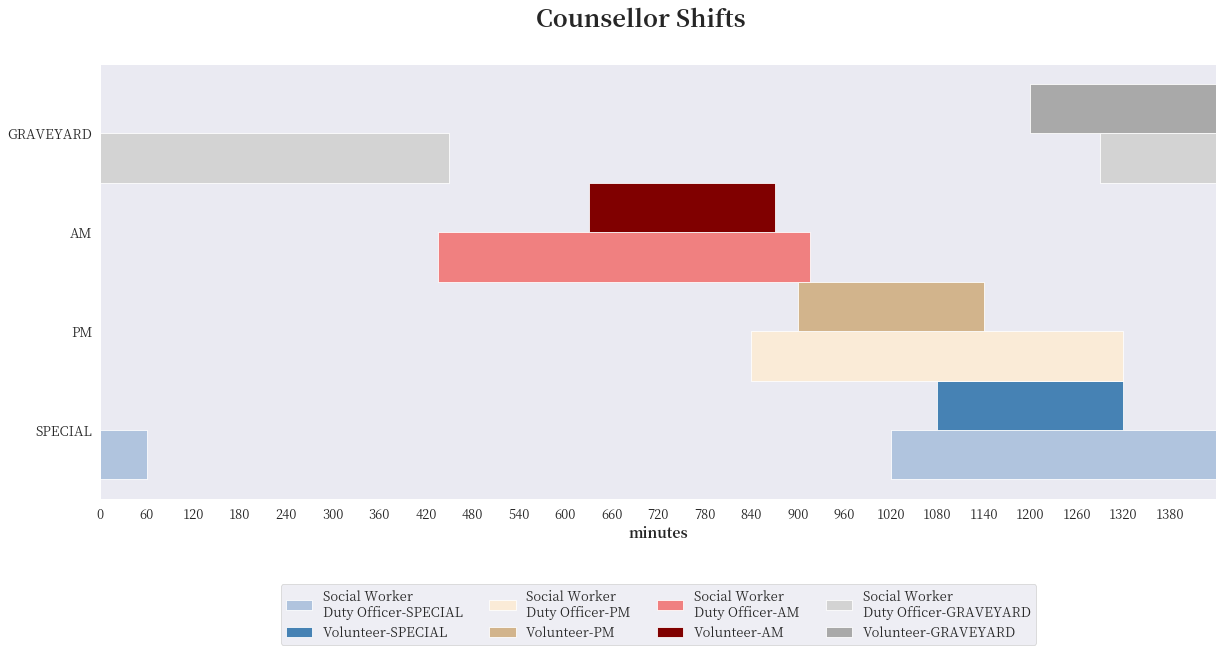

In [4]:
fig, ax = plt.subplots( figsize=(20, 8))
ax.set_xlim(0, 1440)


# special
ax.broken_barh([(SocialWorkerShifts.SPECIAL.start, 1440),
    (0, SocialWorkerShifts.SPECIAL.end%1440)],
    (1, 1), facecolors='lightsteelblue',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.SPECIAL.shift_name}')
ax.broken_barh([(VolunteerShifts.SPECIAL.start,
    VolunteerShifts.PM.duration)],
    (2, 1), facecolors='steelblue',
    label=f'Volunteer-{VolunteerShifts.SPECIAL.shift_name}')


# PM
ax.broken_barh([(SocialWorkerShifts.PM.start,
    SocialWorkerShifts.PM.duration)],
    (3, 1), facecolors='antiquewhite',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.PM.shift_name}'
)
ax.broken_barh([(VolunteerShifts.PM.start,
    VolunteerShifts.PM.duration)],
    (4, 1), facecolors='tan',
    label=f'Volunteer-{VolunteerShifts.PM.shift_name}'
)



# AM
ax.broken_barh([(SocialWorkerShifts.AM.start, 
    SocialWorkerShifts.AM.duration)],
    (5, 1), facecolors='lightcoral',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.AM.shift_name}'
)
ax.broken_barh([(VolunteerShifts.AM.start, 
    VolunteerShifts.AM.duration)],
    (6, 1), facecolors='maroon',
    label=f'Volunteer-{VolunteerShifts.AM.shift_name}'
)


# graveyard
ax.broken_barh([(SocialWorkerShifts.GRAVEYARD.start, 1440),
    (0, SocialWorkerShifts.GRAVEYARD.end%1440)],
    (7, 1), facecolors='lightgrey',
    label=f'Social Worker\nDuty Officer-{SocialWorkerShifts.GRAVEYARD.shift_name}'              
)
ax.broken_barh([(VolunteerShifts.GRAVEYARD.start,
    VolunteerShifts.GRAVEYARD.end)],
    (8, 1), facecolors='darkgrey',
    label=f'Volunteer-{VolunteerShifts.GRAVEYARD.shift_name}',
)


ax.set_xticks([x for x in range(0, 1440, 60)])
ax.set_xlabel('minutes')
ax.set_yticks([x for x in range(2, 9 , 2)])
ax.set_yticklabels([
    SocialWorkerShifts.GRAVEYARD.shift_name,
    SocialWorkerShifts.AM.shift_name,
    SocialWorkerShifts.PM.shift_name,
    SocialWorkerShifts.SPECIAL.shift_name,
    ][::-1])

fig.suptitle('Counsellor Shifts', fontweight='bold', fontsize=24)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.35), ncol=4)

plt.show()

# 2. Queue Simulation (multi-process to speed up bootstrap)

In [5]:
import multiprocessing as mp

In [6]:
manager = mp.Manager()

In [7]:
queue_status = manager.list()
max_queue_length = manager.list()
num_users = manager.list()
num_users_accepted_TOS = manager.list()
num_users_rejected_TOS = manager.list()
num_users_served = manager.list()
num_users_served_g_regular = manager.list()
num_users_served_g_repeated = manager.list()
num_users_reneged = manager.list()
# num_users_reneged_g_regular = manager.list()
# num_users_reneged_g_repeated = manager.list()
num_available_counsellor_processes = manager.list()
queue_time_stats = manager.list()
renege_time_stats = manager.list()
case_chat_time = manager.list()

In [8]:
# comment out line if not reproducing results
random.seed(728)
num_iterations = 1500 # this should be multiples of num_cores
num_cores = max(mp.cpu_count()-2, 2)

In [9]:
def run_simulation(
        queue_status,
        max_queue_length,
        num_users,
        num_users_accepted_TOS,
        num_users_rejected_TOS,
        num_users_served,
        num_users_served_g_regular,
        num_users_served_g_repeated,
        num_users_reneged,
        num_available_counsellor_processes,
        queue_time_stats,
        renege_time_stats,
        case_chat_time):

    for i in tqdm(
        range(num_iterations//num_cores), 
        desc='OpenUp Queue Simulation'):

        try:
            # create environment
            env = simpy.Environment() 

            # set up service operation and run simulation until  
            S = ServiceOperation(env=env)
            env.run(until=SIMULATION_DURATION)


            num_users.append(S.num_users)   
            num_users_accepted_TOS.append(S.num_users_TOS_accepted)
            num_users_rejected_TOS.append(S.num_users_TOS_rejected)
            max_queue_length.append(S.user_queue_max_length)
            
            queue_status.append(pd.DataFrame(S.queue_status) )
            num_available_counsellor_processes.append(
                pd.DataFrame(S.num_available_counsellor_processes,
                             columns=['time', 'num_counsellor_processes_idle'])
            )
            
            num_users_served.append(S.served)
            num_users_served_g_regular.append(S.served_g_regular)
            num_users_served_g_repeated.append(S.served_g_repeated)
            num_users_reneged.append(S.reneged)
            
            queue_time_stats.append(pd.DataFrame(S.queue_time_stats) )
            renege_time_stats.append(pd.DataFrame(S.renege_time_stats) )
            case_chat_time.append(pd.DataFrame(S.case_chat_time,
                                            columns=['cumulative_chat_time']) )
            
        #     num_users_reneged_g_regular.append(S.reneged_g_regular)
        #     num_users_reneged_g_repeated.append(S.reneged_g_repeated)
        except ValueError:
            print(f'Negative delay at {i}.  Results are dropped.')

## divide up jobs to `num_cores`, and merge results when complete

In [10]:
jobs = [mp.Process(target=run_simulation, args=[
            queue_status,
            max_queue_length,
            num_users,
            num_users_accepted_TOS,
            num_users_rejected_TOS,
            num_users_served,
            num_users_served_g_regular,
            num_users_served_g_repeated,
            num_users_reneged,
            num_available_counsellor_processes,
            queue_time_stats,
            renege_time_stats,
            case_chat_time
        ]) for i in range(num_cores)]        
    
for j in jobs:
    j.start()
    
    
for j in jobs:
    j.join()

OpenUp Queue Simulation: 100%|██████████| 250/250 [05:33<00:00,  1.33s/it]


## convert to pandas objects

In [11]:
num_users = pd.Series(np.array(num_users), name='number of users')
num_users_accepted_TOS = pd.Series(np.array(num_users_accepted_TOS), name='number of users accepting TOS')
num_users_rejected_TOS = pd.Series(np.array(num_users_rejected_TOS), name='number of users rejecting TOS')
num_users_served = pd.Series(np.array(num_users_served), name='number of users served')
num_users_served_g_regular = pd.Series(np.array(num_users_served_g_regular), name='number of users served')
num_users_served_g_repeated = pd.Series(np.array(num_users_served_g_repeated), name='number of repeated users served')
num_users_reneged = pd.Series(np.array(num_users_reneged), name='number of users reneged')
# num_users_reneged_g_regular = pd.Series(num_users_reneged_g_regular, name='number of users reneged')
# num_users_reneged_g_repeated = pd.Series(num_users_reneged_g_repeated, name='number of repeated users reneged')
queue_status = pd.concat(queue_status)
max_queue_length = pd.Series(np.array(max_queue_length), name='max queue length')
queue_time_stats = pd.concat(queue_time_stats)
renege_time_stats = pd.concat(renege_time_stats)
num_available_counsellor_processes = pd.concat(num_available_counsellor_processes)
case_chat_time = pd.concat(case_chat_time)

In [12]:
# function to calculate classification confidence intervals
# parameter: stats - list of confidence intervals, which must be ordered
#            metadata - any string to annotate printout, can be None
# precondition - metadata must be a string or None, and stats must be a list
#                  The check is commented out for now as asserts should 
#               be done outside function
# returns: cutoff values at 2.5% and 95% percentiles
def calculate_confidence_intervals(stats, metadata=None):
    # if not isinstance(metadata, None) or \
    #     not isinstance(metadata, str) or \
    #     not isinstance(stats, list):
    #     return
        
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(stats, q_lower)
    upper_percentile = np.percentile(stats, q_upper)
    mean = np.mean(stats)
        
    print('\n%s %d%% Confidence interval:' % (
        metadata, confidence_interval) )
    print('----------------------------')
    print('%.1f%% percentile: %.5f' % (q_lower, lower_percentile) )
    print('%.1f%% percentile: %.5f\n' % (q_upper, upper_percentile) )
    print('mean value: %.5f' % mean)
    return (lower_percentile, upper_percentile, mean)

In [13]:
def plot_distribution(series, filename):
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(series, q_lower)
    upper_percentile = np.percentile(series, q_upper)
    mean = np.mean(series)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5) )
    sns.distplot(series, ax=ax)
    ax.axvline(x=lower_percentile, linestyle='--' )
    ax.axvline(x=upper_percentile, linestyle='--' )
    ax.axvline(x=mean, linestyle=':', linewidth=2 )
    
    fig.savefig(f'{filename}.png', dpi=300, bbox_inches='tight')

/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


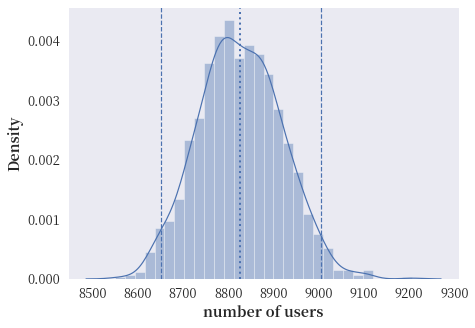

In [14]:
plot_distribution(num_users, 'num_users')

In [15]:
lower, upper, mean = calculate_confidence_intervals(
    num_users.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 8650.47500
97.5% percentile: 9006.00000

mean value: 8826.53800


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


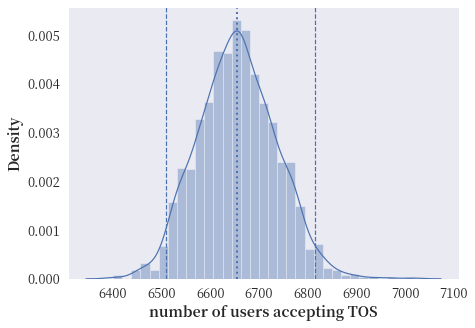

In [16]:
plot_distribution(num_users_accepted_TOS, 'num_users_accepting_TOS')

In [17]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_accepted_TOS.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 6510.47500
97.5% percentile: 6815.00000

mean value: 6655.82400


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


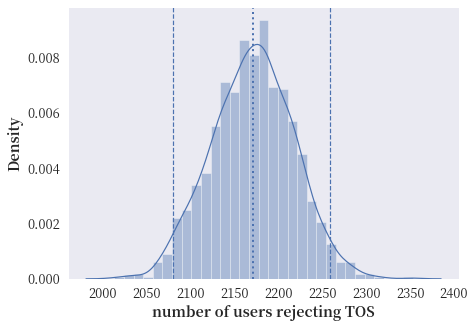

In [18]:
plot_distribution(num_users_rejected_TOS, 'num_users_rejecting_TOS')

In [19]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_rejected_TOS.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 2080.00000
97.5% percentile: 2259.00000

mean value: 2170.71400


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


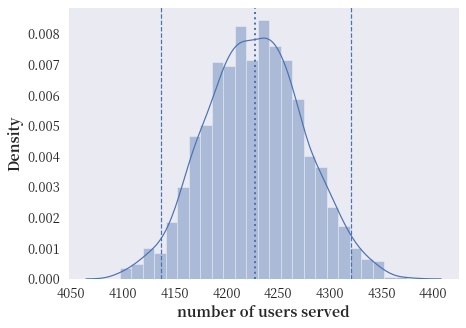

In [20]:
plot_distribution(num_users_served, 'num_users_served')

In [21]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 4136.47500
97.5% percentile: 4321.00000

mean value: 4227.62667


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


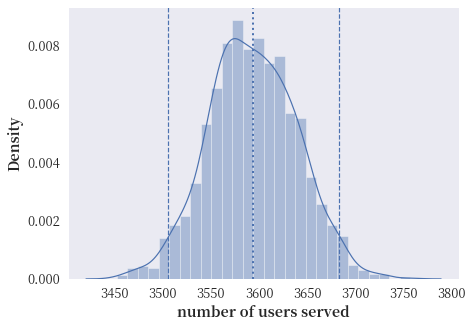

In [22]:
plot_distribution(num_users_served_g_regular, 'num_users_served_g_regular')

In [23]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served_g_regular.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 3505.00000
97.5% percentile: 3683.00000

mean value: 3593.37667


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


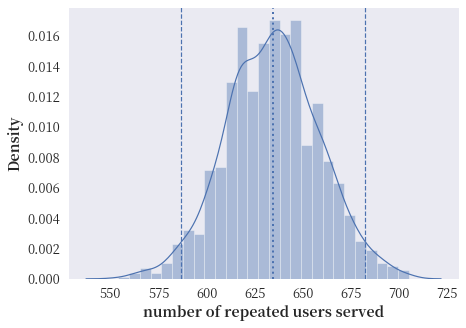

In [24]:
plot_distribution(num_users_served_g_repeated, 'num_users_served_g_repeated')

In [25]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served_g_repeated.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 586.47500
97.5% percentile: 682.00000

mean value: 634.25000


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


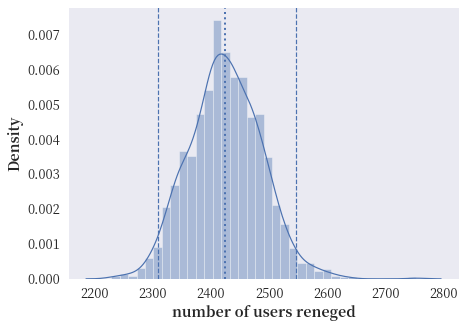

In [26]:
plot_distribution(num_users_reneged, 'num_users_reneged')

In [27]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_reneged.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 2309.47500
97.5% percentile: 2546.52500

mean value: 2424.85533


In [28]:
# plot_distribution(num_users_reneged_g_regular, 'num_users_reneged_g_regular')

In [29]:
# lower, upper, mean = calculate_confidence_intervals(
#     num_users_reneged_g_regular.sort_values().to_list() )

In [30]:
# plot_distribution(num_users_reneged_g_repeated, 'num_users_reneged_g_repeated')

In [31]:
# lower, upper, mean = calculate_confidence_intervals(
#     num_users_reneged_g_repeated.sort_values().to_list() )

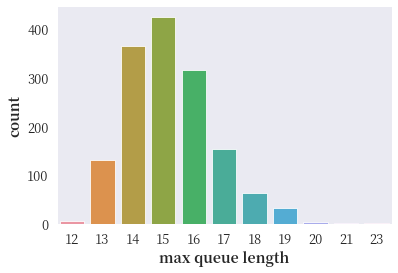

In [32]:
max_queue_length_count = sns.countplot(x='max queue length', data=max_queue_length.to_frame())

max_queue_length_count.get_figure().savefig(f'max_queue_length_count.png', dpi=300, bbox_inches='tight')

In [33]:
queue_status['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}, inplace=True)

In [34]:
queue_status

,weekday,hour,queue_length
0,Sunday,0,0
1,Sunday,0,0
2,Sunday,0,0
3,Sunday,0,0
4,Sunday,0,0
...,...,...,...
7390,Monday,23,3
7391,Monday,23,2
7392,Monday,23,2
7393,Monday,23,1


In [35]:
queue_status['total']=1

# chat time

In [36]:
case_chat_time.describe().T

,count,mean,std,min,25%,50%,75%,max
cumulative_chat_time,6327968.0,52.296369,39.163721,0.000075,23.408725,43.157333,71.248571,507.449793


In [37]:
# case_chat_time[case_chat_time['cumulative_chat_time']>0].describe().T

<AxesSubplot:xlabel='cumulative_chat_time', ylabel='Count'>

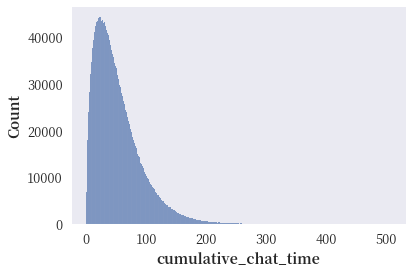

In [38]:
sns.histplot(case_chat_time['cumulative_chat_time'])

<AxesSubplot:xlabel='cumulative_chat_time', ylabel='Density'>

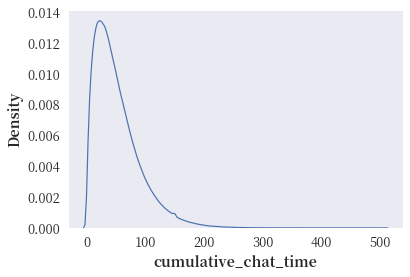

In [39]:
sns.kdeplot(case_chat_time['cumulative_chat_time'])

# queue length

In [40]:
totals = queue_status.groupby(
    ['weekday', 'hour', 'queue_length']).sum()

In [41]:
totals = totals.reset_index()

In [42]:
totals

,weekday,hour,queue_length,total
0,Friday,0,0,756
1,Friday,0,1,2499
2,Friday,0,2,5476
3,Friday,0,3,9099
4,Friday,0,4,12428
...,...,...,...,...
1974,Wednesday,23,14,89
1975,Wednesday,23,15,31
1976,Wednesday,23,16,8
1977,Wednesday,23,17,10


In [43]:
totals = pd.pivot_table(totals, values='total', columns=['queue_length'],
              index=['weekday', 'hour'], aggfunc=np.sum, fill_value=0)

In [44]:
totals_percent = totals.div(totals.sum(axis=1), axis=0)#.round(2)

In [45]:
totals_percent

queue_length          0         1         2         3         4         5   \
weekday   hour                                                               
Friday    0     0.007358  0.024321  0.053294  0.088555  0.120954  0.138443   
          1     0.047065  0.104970  0.164986  0.191395  0.175879  0.134194   
          2     0.148635  0.209404  0.227769  0.182558  0.114481  0.064346   
          3     0.230097  0.255286  0.227093  0.150902  0.081691  0.035634   
          4     0.134854  0.231391  0.258926  0.198657  0.111359  0.045001   
...                  ...       ...       ...       ...       ...       ...   
Wednesday 19    0.966690  0.026421  0.005591  0.000959  0.000266  0.000074   
          20    0.885609  0.049296  0.030720  0.017685  0.008764  0.004546   
          21    0.276788  0.083450  0.100559  0.110841  0.109461  0.095644   
          22    0.042511  0.062264  0.103486  0.134100  0.149821  0.143271   
          23    0.046004  0.066795  0.112668  0.148363  0.158777  0.146101   

queue_length          6         7         8         9   ...        14  \
weekday   hour                                          ...             
Friday    0     0.140185  0.128282  0.105314  0.076555  ...  0.004652   
          1     0.087541  0.050399  0.024735  0.011491  ...  0.000080   
          2     0.031154  0.013558  0.005231  0.002115  ...  0.000000   
          3     0.013473  0.004206  0.001271  0.000300  ...  0.000000   
          4     0.014852  0.004010  0.000653  0.000267  ...  0.000000   
...                  ...       ...       ...       ...  ...       ...   
Wednesday 19    0.000000  0.000000  0.000000  0.000000  ...  0.000000   
          20    0.002057  0.000852  0.000341  0.000131  ...  0.000000   
          21    0.075686  0.056752  0.038424  0.024139  ...  0.000702   
          22    0.123065  0.091049  0.063849  0.040255  ...  0.001298   
          23    0.118250  0.084923  0.054478  0.032113  ...  0.000778   

queue_length          15        16        17        18        19   20   21  \
weekday   hour                                                               
Friday    0     0.001830  0.000886  0.000311  0.000117  0.000010  0.0  0.0   
          1     0.000053  0.000027  0.000013  0.000000  0.000000  0.0  0.0   
          2     0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
          3     0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
          4     0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
...                  ...       ...       ...       ...       ...  ...  ...   
Wednesday 19    0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
          20    0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
          21    0.000266  0.000105  0.000040  0.000008  0.000000  0.0  0.0   
          22    0.000549  0.000218  0.000131  0.000044  0.000009  0.0  0.0   
          23    0.000271  0.000070  0.000087  0.000017  0.000000  0.0  0.0   

queue_length     22   23  
weekday   hour            
Friday    0     0.0  0.0  
          1     0.0  0.0  
          2     0.0  0.0  
          3     0.0  0.0  
          4     0.0  0.0  
...             ...  ...  
Wednesday 19    0.0  0.0  
          20    0.0  0.0  
          21    0.0  0.0  
          22    0.0  0.0  
          23    0.0  0.0  

[168 rows x 24 columns]

In [46]:
totals_percent2 = totals_percent.reset_index()

In [47]:
totals_percent2['day_int'] = totals_percent2['weekday'].map({
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4
})

In [48]:
totals_percent2 = totals_percent2.sort_values(
    by=['day_int', 'hour']).reset_index(drop=True).set_index(
    ['weekday', 'hour']).drop(columns=['day_int'])

In [49]:
totals_percent2['>=2'] = totals_percent2[totals_percent2.columns[totals_percent2.columns >= 2]].sum(axis=1)

In [50]:
totals_percent2.reset_index(inplace=True)

In [51]:
totals_percent3 = totals_percent2[['weekday', 'hour', 0, 1, '>=2']].copy()

In [52]:
from queue_simulation import (
    MINUTES_PER_DAY, DAYS_IN_WEEK, MINUTES_PER_HOUR, 
    MAX_SIMULTANEOUS_CHATS,
    NUM_DUTY_OFFICERS,
    NUM_SOCIAL_WORKERS,
    NUM_VOLUNTEERS
)

In [53]:
NUM_DUTY_OFFICERS

{'GRAVEYARD': 1, 'AM': 1, 'PM': 1, 'SPECIAL': 0}

In [54]:
MAX_SIMULTANEOUS_CHATS

{'SOCIAL_WORKER': 3, 'DUTY_OFFICER': 1, 'VOLUNTEER': 2}

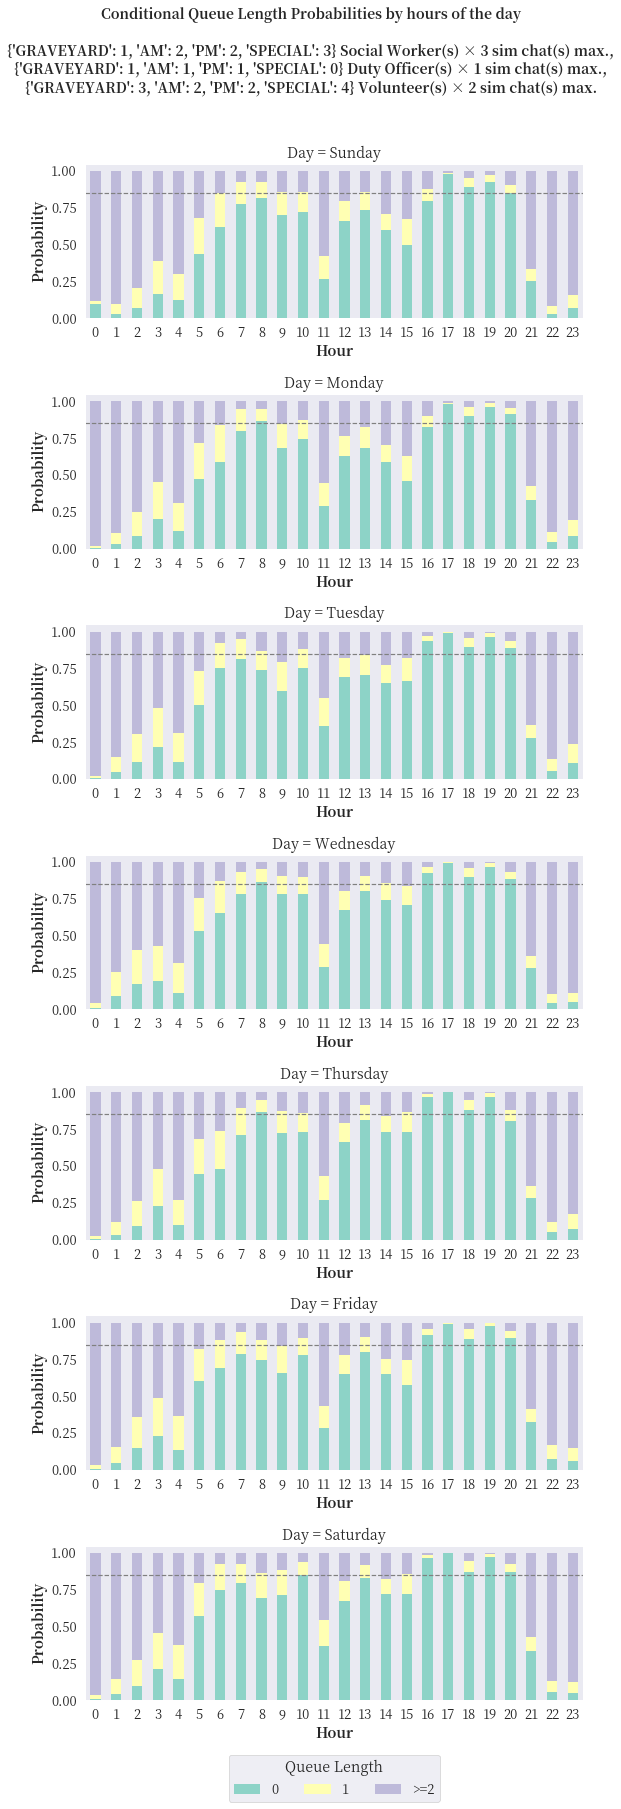

In [55]:
fig, ax = plt.subplots(7, 1, figsize=(8,25) )
palette = sns.color_palette("Set3")

fig.suptitle(f'Conditional Queue Length Probabilities by hours of the day\n\n'
    f'{NUM_SOCIAL_WORKERS} Social Worker(s) × {MAX_SIMULTANEOUS_CHATS["SOCIAL_WORKER"]} sim chat(s) max.,\n'
    f'{NUM_DUTY_OFFICERS} Duty Officer(s) × {MAX_SIMULTANEOUS_CHATS["DUTY_OFFICER"]} sim chat(s) max.,\n'
    f'{NUM_VOLUNTEERS} Volunteer(s) × {MAX_SIMULTANEOUS_CHATS["VOLUNTEER"]} sim chat(s) max.',
    fontsize=14, weight='heavy',
    fontweight=1000, y=1.01)

for i, day in enumerate(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
    'Friday', 'Saturday']):
    
    dataframe = totals_percent3[totals_percent3['weekday']==day].copy()
    dataframe.set_index('hour').plot.bar(
        stacked=True,
        ax=ax[i],
        linewidth=.01,
        color=palette
    )

    ax[i].axhline(y=.85, linestyle='--', color='grey')
#     ax[i].set_xticklabels(labels=[f'{x[:3]}-{x[-1]} hr' 
#         if x[-2:] == '_0' else ''
#         for x in dataframe.index])

    ax[i].set_xlabel('Hour')
    ax[i].set_ylabel('Probability')
    ax[i].set_title(f'Day = {day}')
    ax[i].set_xticklabels(dataframe['hour'], rotation=0)
    
    
    
    if day == 'Saturday':
        ax[i].legend(loc='lower center', 
                     bbox_to_anchor=(0.5, -.7), 
                     ncol=3,
                     title='Queue Length'
                    
                    )
    else:
        ax[i].get_legend().remove()

    
fig.tight_layout()

fig.savefig(f'queue_length_prob_plot.png', dpi=300, bbox_inches='tight')

# queue time

In [56]:
# queue_plot = sns.catplot(col='weekday', y='hour', col_wrap=4,
#     col_order=['Sunday',
#         'Monday',
#         'Tuesday',
#         'Wednesday',
#         'Thursday',
#         'Friday',
#         'Saturday'],
#     data=queue_status, kind="count",
#     height=4, aspect=1);
# queue_plot.savefig(f'queue_blowup.png', dpi=300, bbox_inches='tight')

In [57]:
queue_time_stats['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}, inplace=True)

In [58]:
queue_time_stats

,weekday,hour,time_spent_in_queue
0,Sunday,0,0.000000
1,Sunday,0,0.000000
2,Sunday,0,0.000000
3,Sunday,0,0.000000
4,Sunday,0,0.000000
...,...,...,...
4678,Monday,23,0.000000
4679,Monday,23,6.329039
4680,Monday,23,5.361179
4681,Monday,23,6.225791


In [59]:
queue_time_stats['total']=1

In [60]:
# # totals = 
# queue_time_stats.mean()

In [61]:
queue_time_stats['queue_time_group'] = queue_time_stats['time_spent_in_queue'].apply(
    lambda x: 'direct' if x==0 else '<=5 minutes' if x<=5 and x>0 else '>5 minutes')

In [62]:
queue_time_stats['queue_time_group']

0           direct
1           direct
2           direct
3           direct
4           direct
           ...    
4678        direct
4679    >5 minutes
4680    >5 minutes
4681    >5 minutes
4682    >5 minutes
Name: queue_time_group, Length: 6919241, dtype: object

In [63]:
queue_time_stats = pd.pivot_table(queue_time_stats, values='total', columns=['queue_time_group'],
              index=['weekday', 'hour'], aggfunc=np.sum, fill_value=0)

In [64]:
queue_time_stats

queue_time_group  <=5 minutes  >5 minutes  direct
weekday   hour                                   
Friday    0               271       14296     249
          1               747       13704     456
          2              1106       11255    1383
          3              1617        9942    2556
          4               303        2482     524
...                       ...         ...     ...
Wednesday 19              515         244   66804
          20             4888        4836   63567
          21            11151       34045   33619
          22             2741       36541    2926
          23             3281       38271    1905

[168 rows x 3 columns]

In [65]:
queue_time_stats.div(queue_time_stats.sum(axis=1), axis=0)

queue_time_group  <=5 minutes  >5 minutes    direct
weekday   hour                                     
Friday    0          0.018291    0.964903  0.016806
          1          0.050111    0.919300  0.030590
          2          0.080471    0.818903  0.100626
          3          0.114559    0.704357  0.181084
          4          0.091568    0.750076  0.158356
...                       ...         ...       ...
Wednesday 19         0.007623    0.003611  0.988766
          20         0.066693    0.065984  0.867323
          21         0.141483    0.431961  0.426556
          22         0.064940    0.865736  0.069323
          23         0.075500    0.880664  0.043836

[168 rows x 3 columns]

In [66]:
queue_time_stats_percent = (queue_time_stats.div(queue_time_stats.sum(axis=1), axis=0))#.round(2)

In [67]:
queue_time_stats

queue_time_group  <=5 minutes  >5 minutes  direct
weekday   hour                                   
Friday    0               271       14296     249
          1               747       13704     456
          2              1106       11255    1383
          3              1617        9942    2556
          4               303        2482     524
...                       ...         ...     ...
Wednesday 19              515         244   66804
          20             4888        4836   63567
          21            11151       34045   33619
          22             2741       36541    2926
          23             3281       38271    1905

[168 rows x 3 columns]

In [68]:
queue_time_stats2 = queue_time_stats_percent.reset_index()

In [69]:
queue_time_stats2['day_int'] = queue_time_stats2['weekday'].map({
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4
})

In [70]:
queue_time_stats2 = queue_time_stats2.sort_values(
    by=['day_int', 'hour']).reset_index(drop=True).set_index(
    ['weekday', 'hour']).drop(columns=['day_int'])

In [71]:
queue_time_stats2

queue_time_group  <=5 minutes  >5 minutes    direct
weekday  hour                                      
Sunday   0           0.016670    0.567302  0.416029
         1           0.032667    0.946353  0.020981
         2           0.057841    0.891812  0.050347
         3           0.091867    0.790134  0.117999
         4           0.106278    0.699435  0.194287
...                       ...         ...       ...
Saturday 19          0.005869    0.003504  0.990626
         20          0.071028    0.072951  0.856021
         21          0.125087    0.387738  0.487175
         22          0.075911    0.778277  0.145811
         23          0.073855    0.884539  0.041606

[168 rows x 3 columns]

In [72]:
queue_time_stats2.reset_index(inplace=True)

In [73]:
queue_time_stats2

queue_time_group,weekday,hour,<=5 minutes,>5 minutes,direct
0,Sunday,0,0.016670,0.567302,0.416029
1,Sunday,1,0.032667,0.946353,0.020981
2,Sunday,2,0.057841,0.891812,0.050347
3,Sunday,3,0.091867,0.790134,0.117999
4,Sunday,4,0.106278,0.699435,0.194287
...,...,...,...,...,...
163,Saturday,19,0.005869,0.003504,0.990626
164,Saturday,20,0.071028,0.072951,0.856021
165,Saturday,21,0.125087,0.387738,0.487175
166,Saturday,22,0.075911,0.778277,0.145811


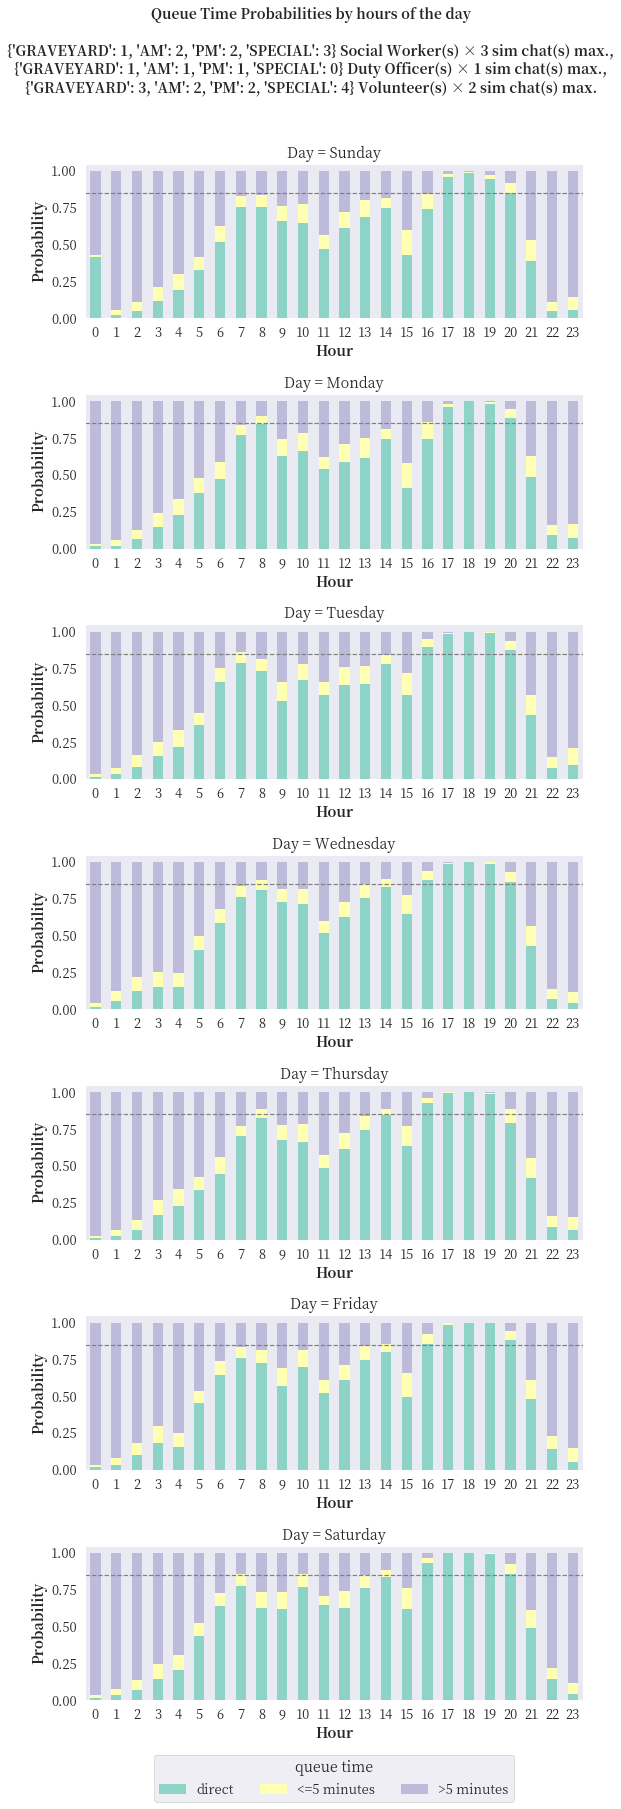

In [74]:
fig, ax = plt.subplots(7, 1, figsize=(8,25) )
palette = sns.color_palette("Set3")

fig.suptitle(f'Queue Time Probabilities by hours of the day\n\n'
    f'{NUM_SOCIAL_WORKERS} Social Worker(s) × {MAX_SIMULTANEOUS_CHATS["SOCIAL_WORKER"]} sim chat(s) max.,\n'
    f'{NUM_DUTY_OFFICERS} Duty Officer(s) × {MAX_SIMULTANEOUS_CHATS["DUTY_OFFICER"]} sim chat(s) max.,\n'
    f'{NUM_VOLUNTEERS} Volunteer(s) × {MAX_SIMULTANEOUS_CHATS["VOLUNTEER"]} sim chat(s) max.',
    fontsize=14, weight='heavy',
    fontweight=1000, y=1.01)

for i, day in enumerate(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
    'Friday', 'Saturday']):
    
    dataframe = queue_time_stats2[queue_time_stats2['weekday']==day].copy()
    dataframe[['weekday', 'hour', 'direct', 
         '<=5 minutes', '>5 minutes']
    ].set_index('hour').plot.bar(
        stacked=True,
        ax=ax[i],
        linewidth=.01,
        color=palette
    )

    ax[i].axhline(y=.85, linestyle='--', color='grey')

    ax[i].set_xlabel('Hour')
    ax[i].set_ylabel('Probability')
    ax[i].set_title(f'Day = {day}')
    ax[i].set_xticklabels(dataframe['hour'], rotation=0)
    
    
    
    if day == 'Saturday':
        ax[i].legend(loc='lower center', 
                     bbox_to_anchor=(0.5, -.7), 
                     ncol=3,
                     title='queue time'
                    
                    )
    else:
        ax[i].get_legend().remove()

    
fig.tight_layout()

fig.savefig(f'queue_length_prob_plot.png', dpi=300, bbox_inches='tight')

# determine hours counsellors are maxed out

In [75]:
from queue_simulation import (
    MINUTES_PER_DAY, DAYS_IN_WEEK, MINUTES_PER_HOUR)

In [76]:
num_available_counsellor_processes

,time,num_counsellor_processes_idle
0,0.830168,12
1,11.381527,11
2,14.504792,10
3,24.969150,9
4,25.033202,8
...,...,...
7390,43187.906994,10
7391,43188.910314,10
7392,43190.954795,10
7393,43198.347814,10


In [77]:
num_available_counsellor_processes['time_int'] = num_available_counsellor_processes['time'].astype(int)

In [78]:
num_available_counsellor_processes['current_day_minutes'] = num_available_counsellor_processes['time_int'] % MINUTES_PER_DAY

In [79]:
num_available_counsellor_processes['weekday'] = (num_available_counsellor_processes['time_int'] / MINUTES_PER_DAY).astype(int) % DAYS_IN_WEEK

In [80]:
num_available_counsellor_processes['hour'] = (num_available_counsellor_processes['current_day_minutes'] / MINUTES_PER_HOUR).astype(int)

In [81]:
num_available_counsellor_processes['day_of_week'] = num_available_counsellor_processes['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
})

In [82]:
num_available_counsellor_processes['total']=1

In [83]:
num_available_counsellor_processes

,time,num_counsellor_processes_idle,time_int,current_day_minutes,weekday,hour,day_of_week,total
0,0.830168,12,0,0,0,0,Sunday,1
1,11.381527,11,11,11,0,0,Sunday,1
2,14.504792,10,14,14,0,0,Sunday,1
3,24.969150,9,24,24,0,0,Sunday,1
4,25.033202,8,25,25,0,0,Sunday,1
...,...,...,...,...,...,...,...,...
7390,43187.906994,10,43187,1427,1,23,Monday,1
7391,43188.910314,10,43188,1428,1,23,Monday,1
7392,43190.954795,10,43190,1430,1,23,Monday,1
7393,43198.347814,10,43198,1438,1,23,Monday,1


In [84]:
df2 = pd.pivot_table(num_available_counsellor_processes, values='total', columns=['num_counsellor_processes_idle'],
              index=[#'weekday', 'day_of_week', 
                     'hour'], aggfunc=np.sum, fill_value=0)

In [85]:
df2 = (((df2.T/df2.T.sum()).T)*100)#.round(2)

In [86]:
# df2 = df2.reset_index(drop=False).drop(columns=['weekday'])
# selection = df2[df2['day_of_week']=='Monday'].copy()

In [87]:
# df2.groupby('hour').mean()

In [88]:
# selection.set_index(['day_of_week', 'hour']).to_excel(
#     'queue_output/num_idle_procs_SW_2434_DO_11_V_2423-45.xlsx')

In [89]:
queue_time_stats

queue_time_group  <=5 minutes  >5 minutes  direct
weekday   hour                                   
Friday    0               271       14296     249
          1               747       13704     456
          2              1106       11255    1383
          3              1617        9942    2556
          4               303        2482     524
...                       ...         ...     ...
Wednesday 19              515         244   66804
          20             4888        4836   63567
          21            11151       34045   33619
          22             2741       36541    2926
          23             3281       38271    1905

[168 rows x 3 columns]

In [90]:
renege_time_stats['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}, inplace=True)

In [91]:
renege_time_stats['time_spent_in_queue'].describe()

count    4.142327e+06
mean     1.440465e+01
std      1.078400e+01
min      2.046206e-01
25%      6.902233e+00
50%      1.150940e+01
75%      1.866739e+01
max      1.893531e+02
Name: time_spent_in_queue, dtype: float64

<AxesSubplot:xlabel='time_spent_in_queue', ylabel='Density'>

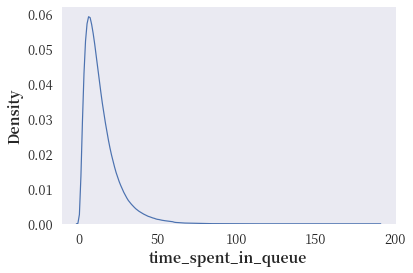

In [92]:
sns.kdeplot(renege_time_stats['time_spent_in_queue'])

<AxesSubplot:xlabel='hour', ylabel='Count'>

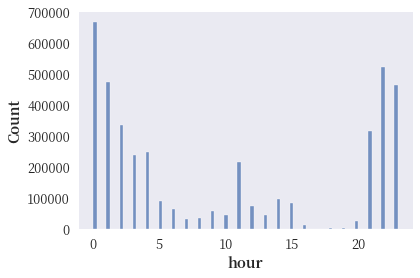

In [93]:
sns.histplot(renege_time_stats['hour'])

In [94]:
df2

num_counsellor_processes_idle,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
hour,,,,,,,,,,,,,,,,,,,,,
0,0.000382,0.023531,0.039431,0.069449,0.113841,0.156833,0.198808,0.242945,0.313031,3.988883,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,69.926105,30.066346,0.007206,0.000343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,28.268360,71.546779,0.177376,0.007485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.389142,97.920986,0.630547,0.059325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.512039,98.136894,0.323674,0.027393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.944997,66.691308,23.404928,8.958767,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.982782,87.310398,9.391172,2.315649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.210176,18.952264,12.802956,15.597306,18.830212,14.371416,8.311888,5.134835,3.654500,1.713267,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.621101,55.600267,17.439628,13.620940,8.334446,3.560395,0.823223,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [95]:
df2['>10'] = df2[df2.columns[df2.columns > 10]].T.sum()

In [96]:
df2 = df2[[x for x in range(11)] + ['>10']].copy()

In [97]:
df2 = df2.T

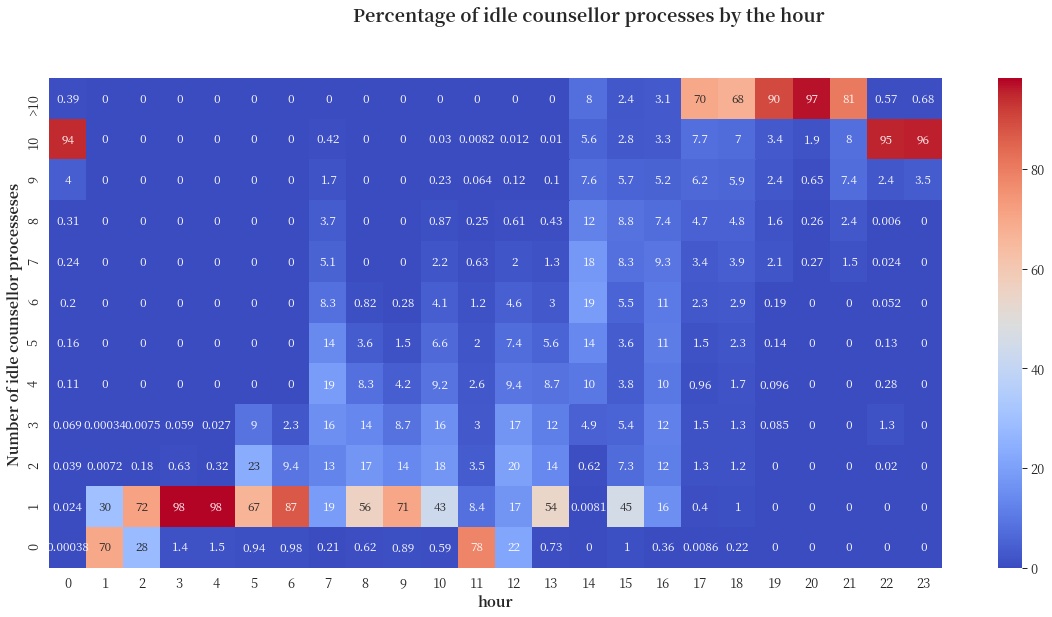

In [98]:
fig, ax = plt.subplots(figsize=(20, 10) )


sns.heatmap(df2[::-1], annot=True, ax=ax, annot_kws={"size": 12}, 
    cmap="coolwarm",
);
fig.suptitle('Percentage of idle counsellor processes by the hour',
    fontsize=18, weight='heavy',
    fontweight=1000)
plt.subplots_adjust(bottom=0.2)
ax.set_ylabel('Number of idle counsellor processeses')

# fig.savefig(f'queue_output/Queue_SW_24_DO_11_V_21.png', dpi=300, bbox_inches='tight')
plt.show()

In [99]:
df2

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
num_counsellor_processes_idle,,,,,,,,,,,,,,,,,,,,,
0,0.000382,69.926105,28.268360,1.389142,1.512039,0.944997,0.982782,0.210176,0.621101,0.889149,...,0.000000,1.017611,0.364452,0.008568,0.220478,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.023531,30.066346,71.546779,97.920986,98.136894,66.691308,87.310398,18.952264,55.600267,70.525347,...,0.008117,45.439302,15.613958,0.398432,1.049446,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.039431,0.007206,0.177376,0.630547,0.323674,23.404928,9.391172,12.802956,17.439628,14.008175,...,0.624978,7.273313,11.878854,1.341816,1.151889,0.000000,0.000000,0.000000,0.020272,0.000000
3,0.069449,0.000343,0.007485,0.059325,0.027393,8.958767,2.315649,15.597306,13.620940,8.656994,...,4.856826,5.392385,12.166977,1.519825,1.269018,0.084787,0.000000,0.000000,1.306187,0.000000
4,0.113841,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.830212,8.334446,4.182341,...,9.983409,3.801190,10.167736,0.964377,1.697644,0.096208,0.000000,0.000000,0.277408,0.000000
5,0.156833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.371416,3.560395,1.459117,...,13.999212,3.583232,10.943611,1.533320,2.261531,0.139570,0.000000,0.000000,0.126256,0.000000
6,0.198808,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.311888,0.823223,0.278877,...,18.833598,5.514848,10.625502,2.344965,2.918251,0.192223,0.000000,0.000000,0.051925,0.000000
7,0.242945,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.134835,0.000000,0.000000,...,17.977536,8.349317,9.322871,3.392455,3.886650,2.109031,0.269482,1.521633,0.024421,0.000000
8,0.313031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.654500,0.000000,0.000000,...,12.474486,8.774487,7.381087,4.714778,4.805368,1.564109,0.255676,2.354765,0.006046,0.000000
